### Import libraries and features 

In [1]:
import gc
import sys
import os 
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from data_set_up import *
from linear_car_price import *
%load_ext autoreload
%autoreload 2

### Import data and split into train and test 

In [4]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")
features,y = data.drop("price",axis=1), data.price

In [5]:
data_setup = DataSetUp(features,y)

In [6]:
X_train,X_test,y_train,y_test = data_setup.data_split(2020,0.1)

### garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Generate a base model first 

In [8]:
base_model = ElasticNet(random_state=2020)

In [9]:
CarPrice_Linear = CarPriceLinear(base_model)

In [10]:
CarPrice_Linear.regression_metrics(X_train,y_train,ind="train")

,r2_score,rmse,price_diff_abs_max
train,0.596534,6282.537939,2176.467735


In [11]:
CarPrice_Linear.regression_metrics(X_test,y_test,ind="test")

,r2_score,rmse,price_diff_abs_max
test,0.604662,6065.084875,1286.509677


### Base model predicts r2 score of ~0.6. Not terrible but a root mean squared error of 6200 for a used car price is quite terrible. Let's perform gridsearch to improve the results

### Key parameters

* alpha: default 1 
* l1__ratio: default 0.5 
* max_iter: default 1000
* tol: default 1e-5

In [12]:
params = {
    "alpha":[0.0005,0.005,0.05],
    "l1_ratio":[1,0.5,0],
    "max_iter":[1000,2000],
    "tol":[1e-4,5e-5]
}

In [14]:
CarPrice_Linear.param_search(params,X_train,y_train,V=0)

In [15]:
CarPrice_Linear.regression_metrics(X_train,y_train,True)

,r2_score,rmse,price_diff_abs_max
True,0.838893,3969.992144,1828.726762


In [16]:
CarPrice_Linear.regression_metrics(X_test,y_test,False)

,r2_score,rmse,price_diff_abs_max
False,0.845884,3786.830767,1048.790109


In [17]:
CarPrice_Linear.search_result.best_params_

{'alpha': 0.05, 'l1_ratio': 1, 'max_iter': 2000, 'tol': 0.0001}

In [18]:
tuned_model = CarPrice_Linear.search_result.best_estimator_

### Better than before but 4000 is very high error as well. 

### Let's look at feature importances and which samples have bad results

### Coefficients and look for feature ranking

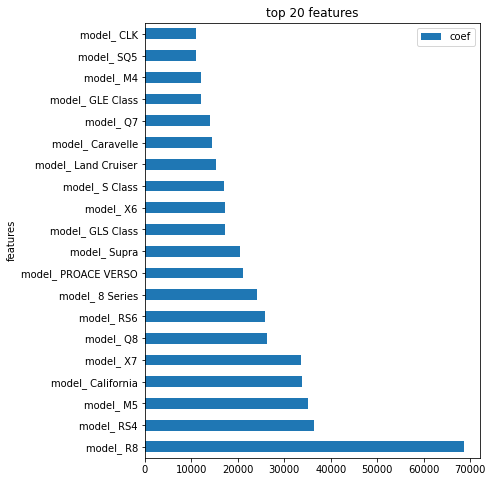

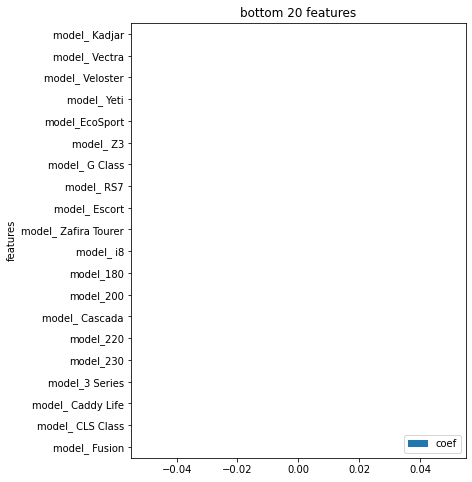

In [19]:
feature_table = CarPrice_Linear.linear_feature_importance(features,plot=True)

### Remove features with very low coef to see if it improve performance. 

* Remove 10 bottom features

In [20]:
trimmed_features = CarPrice_Linear.removeFeatures(features,10)
data_setup_trimmed = DataSetUp(trimmed_features,y)
X_train_trimmed,X_test_trimmed,y_train_trimmed,y_test_trimmed = data_setup_trimmed.data_split(1988,0.1)

In [21]:
CarPrice_Linear.regression_metrics(X_train_trimmed,y_train_trimmed,["train"])

,r2_score,rmse,price_diff_abs_max
train,0.840842,3926.905348,1812.676786


In [22]:
CarPrice_Linear.regression_metrics(X_test_trimmed,y_test_trimmed,["test"],False)

,r2_score,rmse,price_diff_abs_max
test,0.822656,4243.211111,425.157566


### Similar performance but with less features
### Look at examples where the price is way off 

In [23]:
price_diff_table = CarPrice_Linear.price_diff(trimmed_features,y)

### Looking at the features with 50 most difference price prediction

In [27]:
price_diff_table.head(25)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
39336,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1812.676786,1812.676786
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1527.785236,1527.785236
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1224.576210,1224.576210
39978,1,5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,941.206100,941.206100
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,924.636402,924.636402
11984,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,873.262737,873.262737
77582,1,4,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,810.245601,810.245601
44309,1,5,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-798.652182,798.652182
44539,1,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-789.916458,789.916458
87481,0,4,1,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,762.443095,762.443095


### Looking at 50 best predicted cars

In [25]:
price_diff_table.tail(50)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
18553,4,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.010046,0.010046
17903,4,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-0.010046,0.010046
39432,2,3,4,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.009717,0.009717
70825,3,3,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-0.009384,0.009384
41554,3,3,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.007968,0.007968
7224,3,2,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.007855,0.007855
47589,3,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.007815,0.007815
47861,3,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,-0.007815,0.007815
23735,3,1,3,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,-0.007656,0.007656
90675,3,3,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.007519,0.007519


### Check overall how the predicted price versus actual price appear and if the residual is guassian

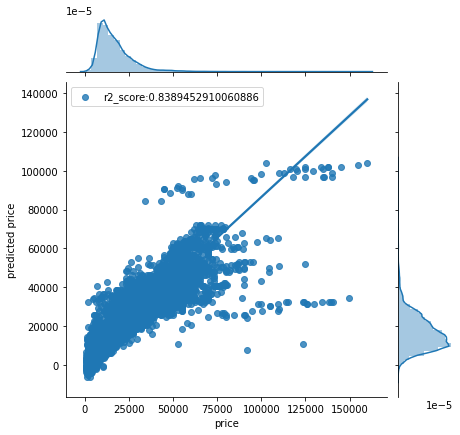

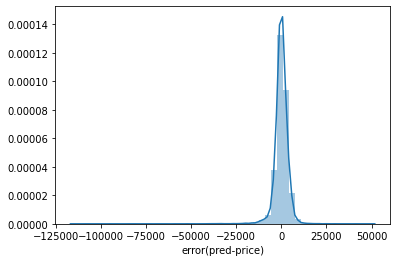

In [26]:
CarPrice_Linear.plot_pred_price(trimmed_features,y)

### summary:

* cars that are older tend to be harder to predict for the price especially if the mileage is low for the age of the car

### Overally not a bad first model:
* residuals are roughly gaussian 
* r2 score is 0.84
_____